In [1]:
import torch
import matplotlib.pyplot as plt
import json

from transformers import ViltProcessor, ViltImageProcessor, ViltModel, ViltConfig, BertTokenizer, ViltForQuestionAnswering
# from processing_vilt import ViltProcessor
# from image_processing_vilt import ViltImageProcessor
from PIL import Image
from torchvision import transforms, models
from torch import nn
from nuscenes.nuscenes import NuScenes
from utility import ViltImageSetProcessor, ViltSetProcessor
from transformers.models.vilt.modeling_vilt import ViltPatchEmbeddings
from transformers.models.vilt.modeling_vilt import ViltEmbeddings
from models import SetEmbeddings, MultiviewViltModel, MultiviewViltForQuestionAnswering

In [2]:
# import os

# def count_files_in_folder(folder_path):
#     return len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])

# def check_folder_consistency(root_folder):
#     folder_sizes = {}
#     for folder in [f for f in os.listdir(root_folder) if os.path.isdir(os.path.join(root_folder, f))]:
#         folder_path = os.path.join(root_folder, folder)
#         num_files = count_files_in_folder(folder_path)
#         folder_sizes[folder] = num_files

#     if len(set(folder_sizes.values())) == 1:
#         print("All folders have the same number of files:", list(folder_sizes.values())[0])
#     else:
#         print("Folders have different numbers of files:")
#         for folder, num_files in folder_sizes.items():
#             print(f"  {folder}: {num_files}")

# # Example usage:
# root_folder = "/home/nikostheodoridis/nuscenes/samples"
# check_folder_consistency(root_folder)

Folders have different numbers of files:
  CAM_FRONT: 34149
  CAM_BACK_RIGHT: 34149
  CAM_FRONT_RIGHT: 34149
  RADAR_FRONT_RIGHT: 34147
  RADAR_FRONT_LEFT: 34147
  RADAR_BACK_LEFT: 34148
  CAM_BACK: 34149
  CAM_BACK_LEFT: 34149
  RADAR_FRONT: 34146
  LIDAR_TOP: 34149
  CAM_FRONT_LEFT: 34149
  RADAR_BACK_RIGHT: 34147


In [2]:
def get_img_paths_from_sample(nusc, sample):

    prefix = "/home/nikostheodoridis/nuscenes/"

    sample_data_list = [nusc.get("sample_data", sample["data"]["CAM_FRONT_LEFT"]),
    nusc.get("sample_data", sample["data"]["CAM_FRONT"]),
    nusc.get("sample_data", sample["data"]["CAM_FRONT_RIGHT"]),
    nusc.get("sample_data", sample["data"]["CAM_BACK_LEFT"]),
    nusc.get("sample_data", sample["data"]["CAM_BACK"]),
    nusc.get("sample_data", sample["data"]["CAM_BACK_RIGHT"])]

    paths = [f"{prefix}{sample_data['filename']}" for sample_data in sample_data_list]    

    return [Image.open(path) for path in paths]

In [3]:
def get_questions_from_sample(qa_set, sample):
    questions = []
    for qa_sample in qa_set["questions"]:
        if qa_sample["sample_token"] == sample["token"]:
            questions.append(qa_sample["question"])

    return questions

In [4]:
from prettytable import PrettyTable
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    cnt = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        cnt += 1
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [5]:
nusc = NuScenes(version='v1.0-trainval', dataroot='/home/nikostheodoridis/nuscenes', verbose=True)

Loading NuScenes tables for version v1.0-trainval...


In [8]:
sample = nusc.sample[0]

In [9]:
train_qa_set_path = "/home/nikostheodoridis/nuscenes-qa/NuScenes_train_questions.json"

with open(train_qa_set_path) as f:
    train_qa_set = json.load(f)

In [10]:
set_processor = ViltSetProcessor()
batch = [get_img_paths_from_sample(nusc, nusc.sample[i]) for i in range(16)]
img = batch[0][0]
questions = [get_questions_from_sample(train_qa_set, nusc.sample[i])[0] for i in range(16)]
inputs = set_processor(batch, questions)

/home/nikostheodoridis/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [11]:
inputs["attention_mask"].shape

torch.Size([16, 40])

In [12]:
type(inputs)

collections.OrderedDict

In [12]:
multiview_vilt_qa = MultiviewViltForQuestionAnswering(6, 210, 768, True, True).to("cuda")

output = multiview_vilt_qa(**inputs)

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.21 GiB. GPU 

: 

In [14]:
output.logits.shape

torch.Size([2, 3129])

In [11]:
count_parameters(multiview_vilt_qa)

+-------------------------------------------------------------------------------------+------------+
|                                       Modules                                       | Parameters |
+-------------------------------------------------------------------------------------+------------+
|                 model.vilt.model.embeddings.set_positional_embedding                |   967680   |
|                   model.vilt.model.embeddings.embeddings.cls_token                  |    768     |
|              model.vilt.model.embeddings.embeddings.position_embeddings             |   111360   |
|    model.vilt.model.embeddings.embeddings.text_embeddings.word_embeddings.weight    |  23440896  |
|  model.vilt.model.embeddings.embeddings.text_embeddings.position_embeddings.weight  |   30720    |
| model.vilt.model.embeddings.embeddings.text_embeddings.token_type_embeddings.weight |    1536    |
|       model.vilt.model.embeddings.embeddings.text_embeddings.LayerNorm.weight       |    

118556217

classifier.0.weight                      |  1179648   |
|                      classifier.0.bias                       |    1536    |
|                     classifier.1.weight                      |    1536    |
|                      classifier.1.bias                       |    1536    |
|                     classifier.3.weight                      |    3072    |
|                      classifier.3.bias                       |     2  

In [17]:
original_vilt_qa = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

In [28]:
for param, param_2 in zip(multiview_vilt_qa.parameters(), original_vilt_qa.parameters()):
    assert torch.equal(param, param_2)

In [10]:
inputs["input_ids"]

tensor([[ 101, 2045, 2003, 1037, 2482, 2000, 1996, 2067, 2157, 1997, 2033, 1025,
         2054, 3570, 2003, 2009, 1029,  102,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0],
        [ 101, 2054, 3570, 2003, 1996, 2518, 2000, 1996, 2392, 1997, 2033, 1029,
          102,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0]])

In [12]:
processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-mlm")
imgs = [batch[0][0], batch[0][1]]
questions = [get_questions_from_sample(train_qa_set, sample)[0], get_questions_from_sample(train_qa_set, sample)[1]]

single_inputs = processor(imgs, questions, return_tensors="pt", max_length=40, padding="max_length")

In [12]:
single_inputs["input_ids"]

tensor([[ 101, 2045, 2003, 1037, 2482, 2000, 1996, 2067, 2157, 1997, 2033, 1025,
         2054, 3570, 2003, 2009, 1029,  102,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0],
        [ 101, 2054, 3570, 2003, 1996, 2518, 2000, 1996, 2392, 1997, 2033, 1029,
          102,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0]])

In [13]:
inputs["pixel_values"].shape

torch.Size([2, 6, 3, 352, 608])

In [17]:
# vilt = ViltModel.from_pretrained("dandelin/vilt-b32-mlm")
# vilt_2 = ViltModel.from_pretrained("dandelin/vilt-b32-mlm")
vilt = ViltModel(ViltConfig())
vilt_2 = ViltModel(ViltConfig())
vilt_emb = vilt.embeddings
vilt_emb_2 = vilt_2.embeddings

emb_out = vilt_emb(**single_inputs, inputs_embeds=None, image_embeds=None)

emb_out_2 = vilt_emb_2(**single_inputs, inputs_embeds=None, image_embeds=None)

torch.equal(torch.sort(emb_out[0], dim=1).values, torch.sort(emb_out_2[0], dim=1).values)

False

In [15]:
emb_out[0].shape

torch.Size([2, 250, 768])

In [16]:
vilt.embeddings.token_type_embeddings == vilt_2.embeddings.token_type_embeddings

False

In [17]:
my_emb = SetEmbeddings(6, 210, 768)

my_emb_out = my_emb(**inputs)
my_emb_out[0].device

device(type='cpu')

In [18]:
emb_out[0].shape

torch.Size([2, 250, 768])

In [21]:
# torch.equal(emb_out[0][0, :42, :], my_emb_out[0][0, :42, :])
torch.equal(torch.sort(emb_out[0][0, :41], dim=0).values, torch.sort(my_emb_out[0][0, :41, :], dim=0).values)

False

In [23]:
emb_out[0][0].shape

torch.Size([250, 768])

In [24]:
my_emb_out[0][0, :250, :].shape

torch.Size([250, 768])

In [22]:
torch.allclose(emb_out[0][0], my_emb_out[0][0, :250, :], atol=1e-6)

False

In [21]:
config = ViltConfig()

In [22]:
torch.equal(torch.full_like(inputs["pixel_mask"], 1, dtype=torch.long), torch.ones_like(inputs["pixel_mask"]))

True

In [78]:
x = nn.Embedding(config.modality_type_vocab_size, config.hidden_size)
pos = torch.arange(2)
pos_emb = x(pos)
pos_emb.shape
pos_emb.sum()

tensor(-13.7112, grad_fn=<SumBackward0>)

tensor(1.9895, grad_fn=<SumBackward0>)

In [57]:
pos_emb

tensor([[ 0.8005, -0.6732,  2.0760,  ..., -0.5649,  0.8031,  1.3401],
        [-0.7955,  0.2930,  1.8728,  ..., -0.7377, -0.1743,  0.1474]],
       grad_fn=<EmbeddingBackward0>)

In [132]:
cnt = 0

for _ in range(1000):
    # cnt += torch.randn(2, 768).sum()
    x = nn.Embedding(config.modality_type_vocab_size, config.hidden_size)
    pos = torch.arange(2)
    pos_emb = x(pos)
    pos_emb.shape
    cnt += pos_emb.sum()

cnt / 1000

tensor(-1.0498, grad_fn=<DivBackward0>)

In [30]:
y = x(torch.ones(768, dtype=torch.long))

In [35]:
z = x(torch.zeros(768, dtype=torch.long))

In [38]:
k = x(torch.ones(40, dtype=torch.long))

In [40]:
k.shape

torch.Size([40, 768])

In [36]:
z

tensor([[ 0.8005, -0.6732,  2.0760,  ..., -0.5649,  0.8031,  1.3401],
        [ 0.8005, -0.6732,  2.0760,  ..., -0.5649,  0.8031,  1.3401],
        [ 0.8005, -0.6732,  2.0760,  ..., -0.5649,  0.8031,  1.3401],
        ...,
        [ 0.8005, -0.6732,  2.0760,  ..., -0.5649,  0.8031,  1.3401],
        [ 0.8005, -0.6732,  2.0760,  ..., -0.5649,  0.8031,  1.3401],
        [ 0.8005, -0.6732,  2.0760,  ..., -0.5649,  0.8031,  1.3401]],
       grad_fn=<EmbeddingBackward0>)

In [34]:
y

tensor([[-0.7955,  0.2930,  1.8728,  ..., -0.7377, -0.1743,  0.1474],
        [-0.7955,  0.2930,  1.8728,  ..., -0.7377, -0.1743,  0.1474],
        [-0.7955,  0.2930,  1.8728,  ..., -0.7377, -0.1743,  0.1474],
        ...,
        [-0.7955,  0.2930,  1.8728,  ..., -0.7377, -0.1743,  0.1474],
        [-0.7955,  0.2930,  1.8728,  ..., -0.7377, -0.1743,  0.1474],
        [-0.7955,  0.2930,  1.8728,  ..., -0.7377, -0.1743,  0.1474]],
       grad_fn=<EmbeddingBackward0>)

In [33]:
torch.equal(y[17], y[767])

True

In [24]:
count_parameters(x)

+---------+------------+
| Modules | Parameters |
+---------+------------+
|  weight |    1536    |
+---------+------------+
Total Trainable Params: 1536


1536

In [28]:
inputs["input_ids"].shape

torch.Size([2, 40])

In [29]:
questions

['There is a car to the back right of me; what status is it?',
 'What status is the thing to the front of me?']

In [43]:
emb = ViltModel.from_pretrained("dandelin/vilt-b32-mlm")
emb(**single_inputs, inputs_embeds=None, image_embeds=None)[0].shape

torch.Size([2, 250, 768])

In [34]:
my_emb = SetEmbeddings(6, 210, 768)
my_emb(**inputs)[1][:, :19]

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]])

In [17]:
emb = ViltEmbeddings(ViltConfig())
emb(**inputs, inputs_embeds=None, image_embeds=None)[0].shape

torch.Size([1, 210, 768])


torch.Size([1, 228, 768])

In [20]:
inputs["pixel_values"].shape

torch.Size([1, 3, 352, 608])

In [17]:
model = ViltModel(ViltConfig())

In [27]:
patch_embeddings_module = model.embeddings.patch_embeddings

In [37]:
count_parameters(model)

+---------------------------------------------------------+------------+
|                         Modules                         | Parameters |
+---------------------------------------------------------+------------+
|                   embeddings.cls_token                  |    768     |
|              embeddings.position_embeddings             |   111360   |
|    embeddings.text_embeddings.word_embeddings.weight    |  23440896  |
|  embeddings.text_embeddings.position_embeddings.weight  |   30720    |
| embeddings.text_embeddings.token_type_embeddings.weight |    1536    |
|       embeddings.text_embeddings.LayerNorm.weight       |    768     |
|        embeddings.text_embeddings.LayerNorm.bias        |    768     |
|      embeddings.patch_embeddings.projection.weight      |  2359296   |
|       embeddings.patch_embeddings.projection.bias       |    768     |
|         embeddings.token_type_embeddings.weight         |    1536    |
|     encoder.layer.0.attention.attention.query.wei

111595008

In [24]:
model(**inputs)

ValueError: too many values to unpack (expected 4)

In [33]:
inputs["pixel_values"].shape

torch.Size([1, 6, 3, 352, 608])

In [35]:
patch_embedding(inputs["pixel_values"][0]).shape

torch.Size([6, 768, 11, 19])

In [11]:
question

'There is a car to the back right of me; what status is it?'

In [13]:
type(inputs)

NoneType

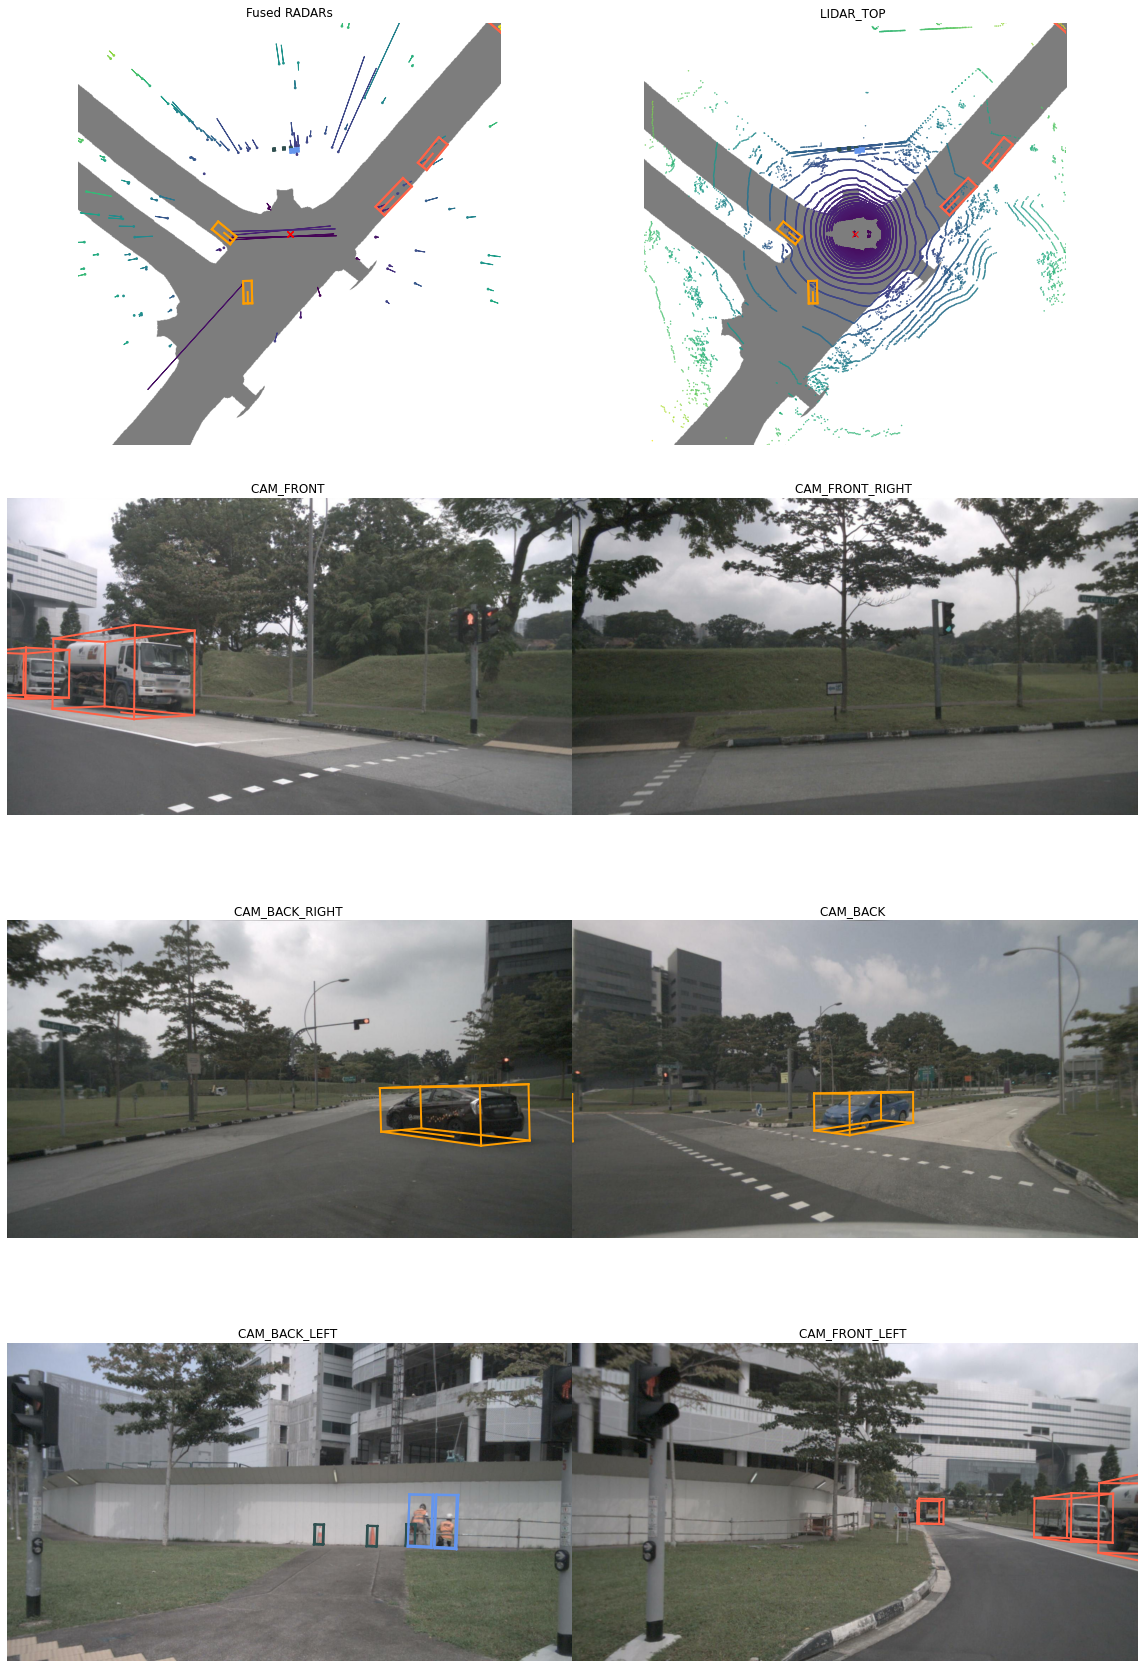

In [35]:
nusc.render_sample(sample["token"])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


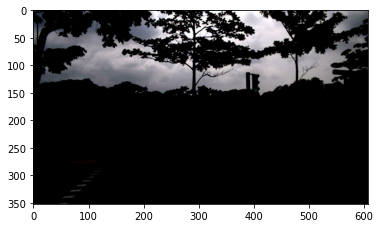

In [37]:
plt.imshow(inputs["pixel_values"][1, 2].permute(1, 2, 0))

In [12]:
inputs["pixel_mask"].shape

torch.Size([2, 6, 352, 608])

In [75]:


# batch = [get_img_paths_from_sample(nusc, sample), get_img_paths_from_sample(nusc, nusc.sample[1])]
imgs = get_img_paths_from_sample(nusc, sample)
question = get_questions_from_sample(train_qa_set, sample)[:6]
processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-mlm")

inputs = processor(imgs, question, return_tensors="pt", padding=True, max_length=40)

/home/nikostheodoridis/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/nikostheodoridis/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2692: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


In [76]:
count_parameters(processor)

AttributeError: 'ViltProcessor' object has no attribute 'named_parameters'

In [66]:
type(batch[0][0])

PIL.JpegImagePlugin.JpegImageFile

In [56]:
inputs["pixel_values"].shape

torch.Size([6, 3, 352, 608])

In [57]:
inputs["input_ids"].shape

torch.Size([6, 18])

In [58]:
inputs["input_ids"].shape

torch.Size([6, 18])

In [59]:
model.embeddings

ViltEmbeddings(
  (text_embeddings): TextEmbeddings(
    (word_embeddings): Embedding(30522, 768)
    (position_embeddings): Embedding(40, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (patch_embeddings): ViltPatchEmbeddings(
    (projection): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
  )
  (token_type_embeddings): Embedding(2, 768)
  (dropout): Dropout(p=0.0, inplace=False)
)

In [60]:
output = model(**inputs)
output.last_hidden_state.shape

torch.Size([6, 228, 768])

In [18]:
output

BaseModelOutputWithPooling(last_hidden_state=tensor([[[-0.1022, -0.1916, -0.6971,  ...,  0.2630, -0.4830, -2.0794],
         [ 0.0554, -0.3191,  0.3423,  ..., -0.3153, -0.6047, -1.5783],
         [ 0.0522, -0.0902, -0.7237,  ..., -0.0785, -1.5855, -0.0956],
         ...,
         [ 0.3916,  0.4847, -0.6130,  ..., -0.0614,  1.0039, -0.3134],
         [ 1.4221,  1.3676, -0.0683,  ..., -0.1048, -0.9852, -0.4080],
         [-0.0129,  0.0738, -0.8166,  ..., -0.4121,  0.9366, -0.9479]]],
       grad_fn=<NativeLayerNormBackward0>), pooler_output=tensor([[-0.8276,  0.1966, -0.6165, -0.9291, -0.3499, -0.4229, -0.0581,  0.4345,
          0.3540, -0.2971, -0.2899, -0.4077, -0.6455, -0.1017, -0.1059,  0.8693,
          0.0038, -0.1626, -0.0768,  0.1304, -0.5084, -0.6619,  0.5131, -0.4177,
         -0.6811, -0.4103,  0.0384, -0.4539, -0.1531,  0.0728, -0.2491, -0.6960,
          0.5482,  0.8289, -0.2660, -0.3632, -0.6104, -0.1058,  0.5166, -0.4685,
          0.0984, -0.5993,  0.5349, -0.1552, -0.32

In [11]:
inputs

{'input_ids': tensor([[ 101, 2129, 2116, 3765, 2024, 2045, 1029,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]]), 'pixel_values': tensor([[[[-0.1922, -0.1922, -0.1922,  ...,  0.1843,  0.1765,  0.1686],
          [-0.1922, -0.1922, -0.1922,  ...,  0.1843,  0.1765,  0.1686],
          [-0.1922, -0.1922, -0.1922,  ...,  0.1843,  0.1765,  0.1686],
          ...,
          [ 0.1137,  0.0980,  0.0980,  ...,  0.1216,  0.1059,  0.1294],
          [ 0.1059,  0.1059,  0.1294,  ...,  0.1686,  0.1686,  0.1686],
          [ 0.1059,  0.1137,  0.1529,  ...,  0.1922,  0.2000,  0.2000]],

         [[-0.2000, -0.2000, -0.2000,  ...,  0.1843,  0.1765,  0.1686],
          [-0.2000, -0.2000, -0.2000,  ...,  0.1843,  0.1765,  0.1686],
          [-0.2000, -0.2000, -0.2000,  ...,  0.1843,  0.1765,  0.1686],
          ...,
          [ 0.1451,  0.1294,  0.1294,  ...,  0.1843,  0.1686,  0.1922],
          [ 0.1529,  0.1451,  0.1608,  ...,  0.215

In [10]:
inputs["pixel_values"].shape

torch.Size([1, 3, 352, 608])

In [4]:
tensor_to_PIL = transforms.ToPILImage()
PIL_to_tensor = transforms.ToTensor()

In [7]:
ones = torch.ones(6)

tensor(1.)

In [9]:
tensor_img = PIL_to_tensor(img)
tensor_img


tensor([[[0.4039, 0.4039, 0.4039,  ..., 0.5843, 0.5843, 0.5804],
         [0.4039, 0.4039, 0.4039,  ..., 0.5843, 0.5843, 0.5804],
         [0.4039, 0.4039, 0.4039,  ..., 0.5843, 0.5843, 0.5804],
         ...,
         [0.5490, 0.5490, 0.5490,  ..., 0.5961, 0.6000, 0.6039],
         [0.5529, 0.5529, 0.5529,  ..., 0.5961, 0.6000, 0.6039],
         [0.5569, 0.5569, 0.5569,  ..., 0.5961, 0.6000, 0.6039]],

        [[0.4000, 0.4000, 0.4000,  ..., 0.5843, 0.5843, 0.5804],
         [0.4000, 0.4000, 0.4000,  ..., 0.5843, 0.5843, 0.5804],
         [0.4000, 0.4000, 0.4000,  ..., 0.5843, 0.5843, 0.5804],
         ...,
         [0.5804, 0.5804, 0.5804,  ..., 0.6118, 0.6157, 0.6196],
         [0.5843, 0.5843, 0.5843,  ..., 0.6118, 0.6157, 0.6196],
         [0.5882, 0.5882, 0.5882,  ..., 0.6118, 0.6157, 0.6196]],

        [[0.3843, 0.3843, 0.3843,  ..., 0.5843, 0.5843, 0.5804],
         [0.3843, 0.3843, 0.3843,  ..., 0.5843, 0.5843, 0.5804],
         [0.3843, 0.3843, 0.3843,  ..., 0.5843, 0.5843, 0.

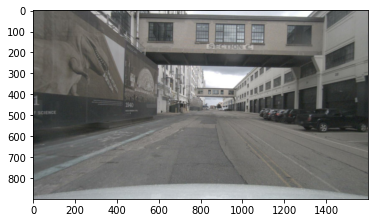

In [16]:
plt.imshow((tensor_img * 1).permute(1, 2, 0))

In [9]:
images = torch.randn(32, 3, 900, 1600)
images_PIL = [tensor_to_PIL(image) for image in images]


img_processor = ViltImageProcessor(size={"shortest_edge": 384})

In [10]:
inputs = img_processor(images_PIL, return_tensors="pt")
# inputs["pixel_values"].shape

In [11]:
batch_of_sets = torch.randn(32, 6, 3, 900, 1600)
batch_of_sets_PIL = [[tensor_to_PIL(image) for image in batch_of_sets[i, :, :, :, :]] for i in range(batch_of_sets.shape[0])]

In [13]:
img_processor = ViltImageProcessor(size={"shortest_edge": 384})

inputs = img_processor(batch_of_sets_PIL, return_tensors="pt", handle_sets=True)

In [14]:
inputs

[[<PIL.Image.Image image mode=RGB size=1600x900 at 0x77B14C40C9A0>,
  <PIL.Image.Image image mode=RGB size=1600x900 at 0x77B034B292A0>,
  <PIL.Image.Image image mode=RGB size=1600x900 at 0x77B034B29BA0>,
  <PIL.Image.Image image mode=RGB size=1600x900 at 0x77B034B29E40>,
  <PIL.Image.Image image mode=RGB size=1600x900 at 0x77B02FA66170>,
  <PIL.Image.Image image mode=RGB size=1600x900 at 0x77B02F32F8B0>],
 [<PIL.Image.Image image mode=RGB size=1600x900 at 0x77B02F32F880>,
  <PIL.Image.Image image mode=RGB size=1600x900 at 0x77B02F32F790>,
  <PIL.Image.Image image mode=RGB size=1600x900 at 0x77B02F32FF40>,
  <PIL.Image.Image image mode=RGB size=1600x900 at 0x77B02F32F730>,
  <PIL.Image.Image image mode=RGB size=1600x900 at 0x77B02F32F700>,
  <PIL.Image.Image image mode=RGB size=1600x900 at 0x77B02F33C430>],
 [<PIL.Image.Image image mode=RGB size=1600x900 at 0x77B02F33C400>,
  <PIL.Image.Image image mode=RGB size=1600x900 at 0x77B02F33C580>,
  <PIL.Image.Image image mode=RGB size=1600x90